In [17]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt


In [18]:
dataset = pd.read_csv('students_simple.csv')
N = 12 
n0 = N % 5
n1 = (N**2) % 5 + 5 
# n0, n1
col_names = dataset.columns

col0 = dataset[col_names[n0]]
col1 = dataset[col_names[n1]]
col0, col1

(0     430
 1     640
 2     610
 3     330
 4     420
 5     290
 6     480
 7     610
 8     840
 9     330
 10    560
 11    450
 12    350
 13    310
 14    380
 15    340
 16    660
 17    450
 18    540
 19    750
 Name: income, dtype: int64,
 0      8.5
 1      6.2
 2      6.8
 3     12.0
 4      7.5
 5     10.0
 6      7.2
 7      4.2
 8      3.5
 9      9.5
 10     7.8
 11     8.0
 12     6.0
 13     4.8
 14     8.6
 15    10.0
 16     4.5
 17    12.5
 18    10.5
 19     6.5
 Name: test_time, dtype: float64)

1. Расчет корреляций

In [19]:
def fechner(data0, data1):
    s0 = np.sign(data0 - np.mean(data0))
    s1 = np.sign(data1 - np.mean(data1))
    nc = np.sum(s0 == s1)
    nd = np.sum(s0 != s1)
    return (nc - nd) / (nc + nd)

fechner(col0, col1)

-0.4

In [20]:
def cov(data0, data1):
    return np.mean((data0 - np.mean(data0)) * (data1 - np.mean(data1))) # mean?

def pearson(data0, data1):
    r = cov(data0, data1) / np.sqrt(cov(data0, data0) * cov(data1, data1))
    n = len(data0)
    alpha = 0.95
    _, v = stats.t.interval(alpha, n - 2)
    v /= np.sqrt(n - 2)
    vr = v / np.sqrt(1 + v ** 2)
    return r, (-vr, vr)

pearson(col0, col1)

(-0.5698939517430253, (-0.44376339933777365, 0.44376339933777365))

In [21]:

def spearman(data0, data1):
    ranks0 = stats.rankdata(data0, method='average')
    ranks1 = stats.rankdata(data1, method='average')
    n = len(data0)
    cof = 6 / (n * (n - 1) * (n + 1))
    return 1 - cof * np.sum((ranks0 - ranks1) ** 2)

spearman(col0, col1)

-0.536842105263158

In [22]:
stats.kendalltau(col0, col1).statistic

-0.43617638325413816

2. Визуализация

Мы знаем, что набор данных $X : \forall i . X[i] \geq 0$. Введем $X^* = X / \max{X}$. Тогда говорить о корелляции $X,Y$ - то же что и о корелляции $X^*,Y^*$.

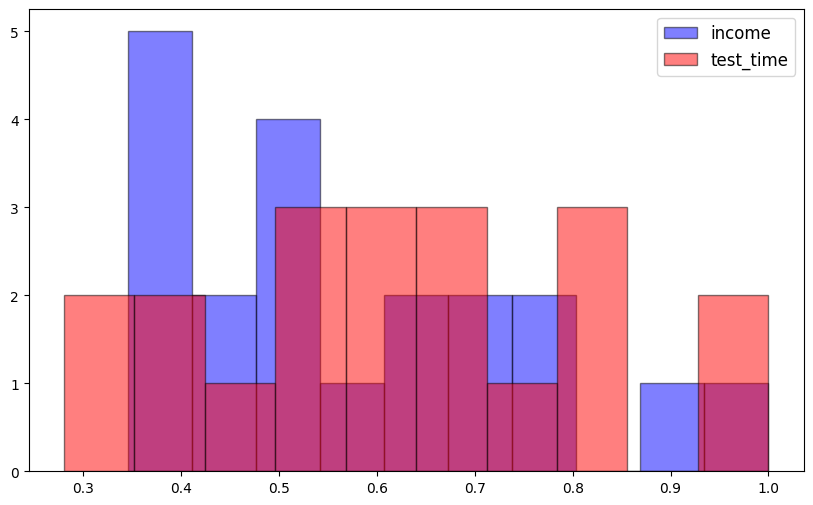

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(col0/np.max(col0) ,alpha=0.5, color='blue', label=col_names[n0], edgecolor='black')
plt.hist(col1/np.max(col1), alpha=0.5, color='red', label=col_names[n1], edgecolor='black')
plt.legend(loc='upper right', fontsize=12)
plt.show()

Text(0, 0.5, 'test_time')

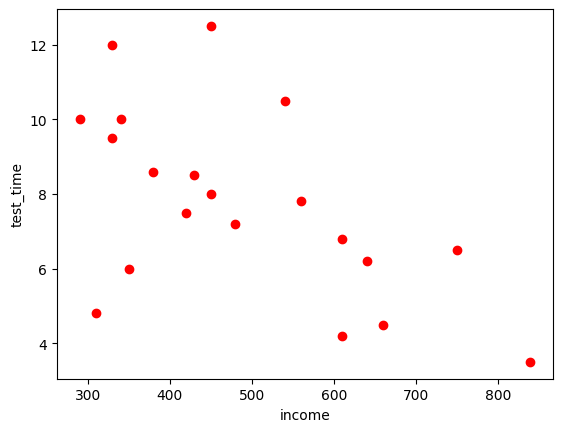

In [24]:
plt.scatter(col0, col1, color='red')
plt.xlabel(col_names[n0])
plt.ylabel(col_names[n1])

3. Уравнение регрессии

In [25]:
from scipy.optimize import curve_fit

def draw_regression(reg, data_x, data_y):
    popt, _ = curve_fit(reg, data_x, data_y)
    xs = np.linspace(np.min(data_x), np.max(data_x), 50)
    opt_fun = np.vectorize(lambda x: reg(x, *popt)) 
    ys = opt_fun(xs)
    loss = np.mean((opt_fun(data_x) - data_y) ** 2)
    
    plt.title(reg.__name__ + " regression")
    plt.plot(xs, ys, color='blue', label=f'regression curve\nloss={loss:.4f}')
    plt.xlabel(data_x.name)
    plt.ylabel(data_y.name)
    plt.scatter(data_x, data_y, color='red', 
                    label=f"({col0.name},{col1.name})")
    plt.legend()
    plt.show()
    return opt_fun

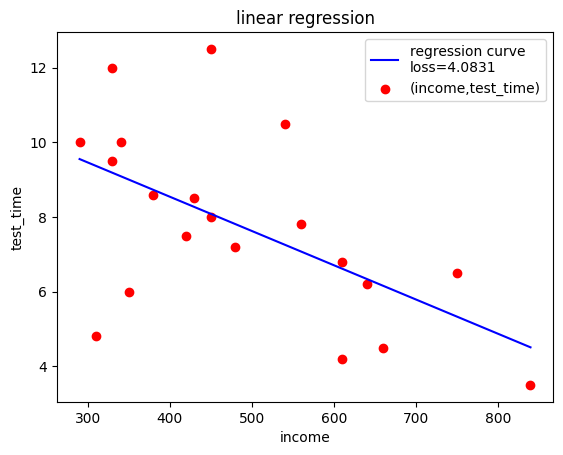

In [26]:
def linear(x, w1, w0):
    return w1 * x + w0 

lin_reg = draw_regression(linear, col0, col1)

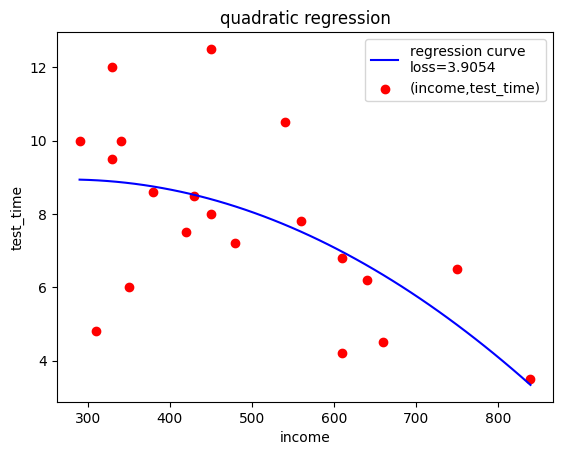

In [27]:
def quadratic(x, w2, w1, w0):
    return w2 * (x ** 2) + w1 * x + w0 

quad_reg = draw_regression(quadratic, col0, col1)

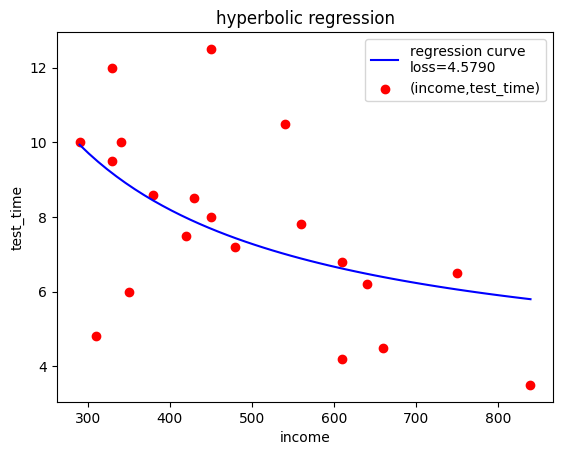

In [28]:
def hyperbolic(x, w1, w0):
    return w1 / x + w0 

hyp_reg = draw_regression(hyperbolic, col0, col1)

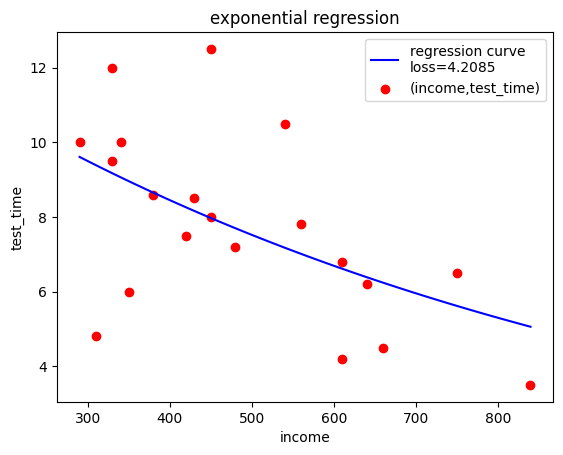

In [29]:
def exponential(x, w1, w0):
    return (w1 ** x) * w0 

exp_reg = draw_regression(exponential, col0, col1)

In [30]:
def fisher_score(data_x, data_y, opt_fun, k):
    l2_fun = np.sum((data_y - opt_fun(data_x)) ** 2)
    l2_mean = np.sum((data_y - np.mean(data_y)) ** 2)
    r2 = 1 - l2_fun / l2_mean
    n = len(data_x)
    F = (r2 / (1 - r2)) * (n - k) / (k - 1)
    return F, stats.f.interval(0.95, k - 1, n - k)

print(fisher_score(col0, col1, hyp_reg, 2))
print(fisher_score(col0, col1, quad_reg, 3))

(5.770903137179299, (0.001009745043408163, 5.978052464789608))
(4.661474086933546, (0.025355550824699646, 4.618874327514398))
